In [25]:
!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"


In [30]:
!unzip -qq master.zip


Exception ignored in: <function _releaseLock at 0x2b99c40c2550>
Traceback (most recent call last):
  File "/shared/centos7/anaconda3/2021.05/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


replace ESC-50-master/.circleci/config.yml? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
!ls

1-137-A-32.wav		 crime_dt.shp			 ondemand
=1.4			 CrissCross			 PA2
celeba			 Data				 pa3
celeba.zip		 dj_baseline.ipynb		 pa3.zip
celeba.zip.1		 ESC-50				 Photo-Judge
celeba.zip.2		 ESC-50-master			 ProtoNet.ipynb
celeba.zip.3		 gans_adversarial_attacks.ipynb  ssast
cifar-100-python	 __MACOSX			 Untitled.ipynb
cifar-100-python.tar.gz  main.py
CNN_Audio.ipynb		 master.zip


In [2]:
%cd ESC-50-master


/home/singh.aditya2/ESC-50-master


In [5]:
!ls

audio	   ESC-50-master  LICENSE     meta	  README.md	    tests
esc50.gif  iris.onnx	  master.zip  pytest.ini  requirements.txt


In [6]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os
import random
import wandb
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork

In [7]:
df = pd.read_csv('meta/esc50.csv')


In [8]:
df.head()


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [9]:
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [10]:
wav, sr = librosa.load('audio/1-100032-A-0.wav', sr=16000)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 16000 and length of the audio is 5.0 seconds


In [11]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

In [12]:
def get_melspectrogram_db(file_path, sr=None, n_fft=1024, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

In [13]:
class ESC50Data(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        self.categories = sorted(df[out_col].unique())
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            file_path = os.path.join(base,row[in_col])
            self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
            self.labels.append(self.c2i[row['category']])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [14]:
class ESC50Model(nn.Module):
    def __init__(self, input_shape, batch_size=16, num_cats=50):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(500, num_cats)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = F.max_pool2d(x, kernel_size=2) 
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.conv6(x)
        x = F.relu(self.bn6(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv7(x)
        x = F.relu(self.bn7(x))
        x = self.conv8(x)
        x = F.relu(self.bn8(x))
        x = x.view(x.size(0),-1)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return x

1-51433-A-17.wav


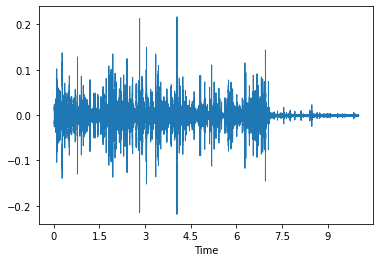

In [15]:
filename = random.choice(os.listdir('audio/'))
wav, sr = librosa.load('audio/'+filename, sr=None)
librosa.display.waveshow(wav)
print(filename)

In [16]:
!ls

audio	   iris.onnx  master.zip  pytest.ini  requirements.txt	wandb
esc50.gif  LICENSE    meta	  README.md   tests


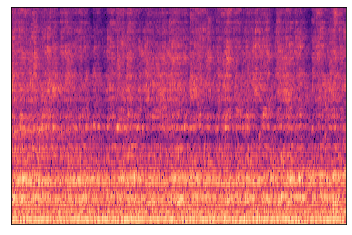

In [17]:
ROOT_PATH = 'audio/'
filename = random.choice(os.listdir(ROOT_PATH))
# filename = 'audio/1-101404-A-34.wav'
# values = get_melspectrogram_db(filename)
librosa.display.specshow(spec_to_image(get_melspectrogram_db(ROOT_PATH+filename)))

In [18]:
train_data = ESC50Data('audio', train, 'filename', 'category')


<ipython-input-13-a00dabe2e41f>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ind in tqdm(range(len(df))):


  0%|          | 0/1600 [00:00<?, ?it/s]

In [19]:
valid_data = ESC50Data('audio', valid, 'filename', 'category')


<ipython-input-13-a00dabe2e41f>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ind in tqdm(range(len(df))):


  0%|          | 0/400 [00:00<?, ?it/s]

In [20]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

In [21]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

In [22]:
args = {"dataset" : 'ESC-50',
    "epochs" : 100,
    "learning_rate" : 2e-5,
    "optimizer" : 'Adam',
    "loss_function" : 'CrossEntropyLoss',
    "log_interval": 10
}
wandb.init(config=args)
model = ESC50Model(input_shape=(1,128,431), batch_size=16, num_cats=50).to(device)
wandb.watch(model, log_freq=100)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: iammoy23 (singh-aditya2). Use `wandb login --relogin` to force relogin


[]

In [23]:
import wandb
print(wandb.__path__)

['/home/singh.aditya2/.local/lib/python3.8/site-packages/wandb']


In [24]:
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [25]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100
train_losses = []
valid_losses = []

In [26]:
args['log_interval']

10

In [27]:
acc = []
losses = []
wandb.watch(model, log_freq=100)
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay=None):
    for epoch in tqdm(range(1,epochs+1)):
        model.train()
        batch_losses=[]
        #if lr_decay:
        #   optimizer = lr_decay(optimizer, epoch)
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        wandb.log({"loss_train_per_epoch": loss})    
        train_losses.append(batch_losses)
        print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss_valid = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss_valid.item())
        losses.append(np.mean(batch_losses))    
        wandb.log({"loss_valid_per_epoch": loss_valid})
        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        acc.append(accuracy)
        wandb.log({"accuracry_validation_per_epoch": accuracy})
        
        print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [28]:
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses)

<ipython-input-27-9f94dd8caa4a>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(1,epochs+1)):


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 3.826563465595245
Epoch - 1 Valid-Loss : 3.412113447189331 Valid-Accuracy : 0.1575
Epoch - 2 Train-Loss : 3.1492989683151245
Epoch - 2 Valid-Loss : 2.9330127906799315 Valid-Accuracy : 0.2875
Epoch - 3 Train-Loss : 2.585983568429947
Epoch - 3 Valid-Loss : 2.617830629348755 Valid-Accuracy : 0.3475
Epoch - 4 Train-Loss : 2.0687191772460936
Epoch - 4 Valid-Loss : 2.35476083278656 Valid-Accuracy : 0.3975
Epoch - 5 Train-Loss : 1.582648419737816
Epoch - 5 Valid-Loss : 2.2300698137283326 Valid-Accuracy : 0.425
Epoch - 6 Train-Loss : 1.2002872627973558
Epoch - 6 Valid-Loss : 2.048915510177612 Valid-Accuracy : 0.48
Epoch - 7 Train-Loss : 0.8845464935898781
Epoch - 7 Valid-Loss : 1.9583227491378785 Valid-Accuracy : 0.4725
Epoch - 8 Train-Loss : 0.725433429479599
Epoch - 8 Valid-Loss : 1.8845681571960449 Valid-Accuracy : 0.5225
Epoch - 9 Train-Loss : 0.5337695457041264
Epoch - 9 Valid-Loss : 1.9165136480331422 Valid-Accuracy : 0.49
Epoch - 10 Train-Loss : 0.4017787846922874

In [40]:
len(acc)

100

In [41]:
acc

[0.1575,
 0.2875,
 0.3475,
 0.3975,
 0.425,
 0.48,
 0.4725,
 0.5225,
 0.49,
 0.525,
 0.5175,
 0.5225,
 0.53,
 0.5325,
 0.5375,
 0.5325,
 0.515,
 0.5475,
 0.5375,
 0.5275,
 0.5075,
 0.52,
 0.5225,
 0.54,
 0.53,
 0.5225,
 0.525,
 0.5325,
 0.5025,
 0.5475,
 0.52,
 0.54,
 0.52,
 0.5275,
 0.535,
 0.515,
 0.525,
 0.5575,
 0.5325,
 0.4875,
 0.525,
 0.54,
 0.5275,
 0.5325,
 0.53,
 0.5175,
 0.4875,
 0.5175,
 0.525,
 0.51,
 0.5375,
 0.5225,
 0.515,
 0.5425,
 0.5375,
 0.5375,
 0.5375,
 0.485,
 0.51,
 0.4775,
 0.5475,
 0.535,
 0.5075,
 0.47,
 0.515,
 0.5125,
 0.5425,
 0.54,
 0.505,
 0.545,
 0.53,
 0.525,
 0.535,
 0.535,
 0.5375,
 0.5225,
 0.54,
 0.545,
 0.5325,
 0.51,
 0.54,
 0.5375,
 0.4,
 0.4375,
 0.4725,
 0.49,
 0.5,
 0.535,
 0.525,
 0.52,
 0.5025,
 0.5375,
 0.52,
 0.5,
 0.55,
 0.525,
 0.5225,
 0.5125,
 0.5325,
 0.505]

In [43]:
len(valid_losses)

100

In [44]:
len(train_losses)

100

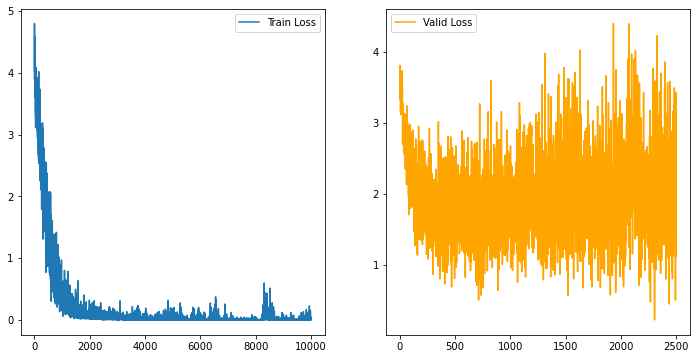

In [30]:
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

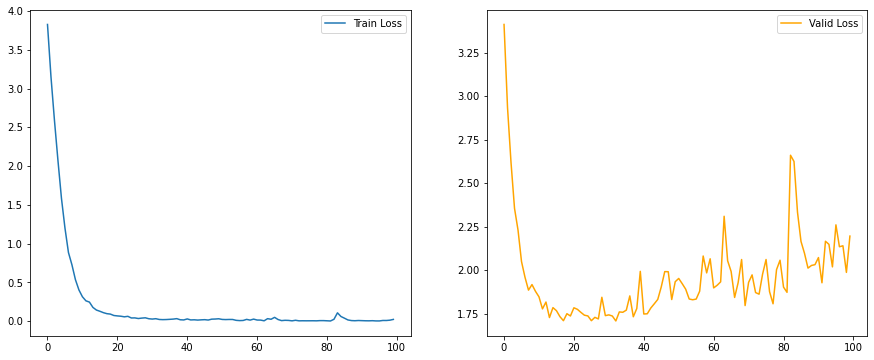

In [98]:
tl = np.asarray(train_losses_)
vl = np.asarray(valid_losses_)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

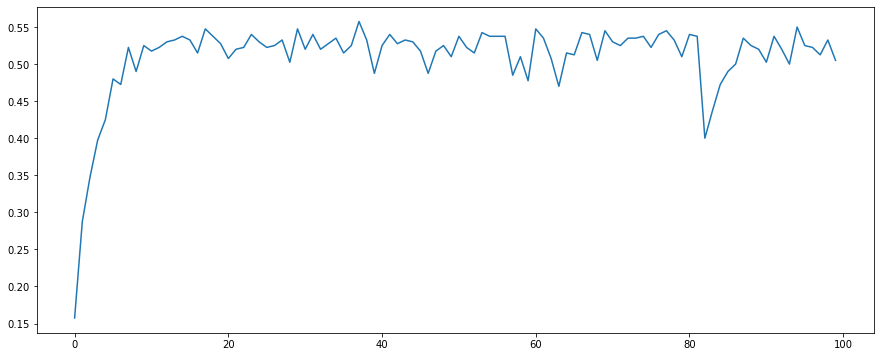

In [99]:
plt.figure(figsize=(15,6))
plt.plot(np.asarray(acc))

In [31]:
file_path = random.choice(os.listdir('audio/'))
print(file_path)
sample_input = spec_to_image(get_melspectrogram_db('audio/'+file_path))[np.newaxis,...]

1-67033-A-37.wav


In [32]:
sample_input
sample_input = torch.from_numpy(sample_input)
sample_input = sample_input.to(device, dtype=torch.float32)

In [33]:
sample_input.shape

torch.Size([1, 128, 431])

In [ ]:
torch.onnx.export(model, sample_input[np.newaxis,...], 'CNN_Scratch.onnx', input_names=["spectogram"], output_names=["logits"])

In [45]:
!ls


Accuracy.txt  esc50.gif   meta	      requirements.txt	Train_loss.txt
audio	      LICENSE	  pytest.ini  Test_loss.txt	wandb
CNN.onnx      master.zip  README.md   tests


In [ ]:
file = open('Accuracy.txt','w')
for item in acc:
    file.write(item+",")
file.close()


In [36]:
!pip install onnx

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.5 MB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 92.5 MB/s eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.22.3
    Uninstalling protobuf-4.22.3:
      Successfully uninstalled protobuf-4.22.3
ERROR: Could not install packages due to an OSError: [Errno 16] Device or resource busy: '.nfs000000094d82c47c00012104'



In [52]:
import math

In [56]:
v_loss= np.asarray(valid_losses)

In [82]:
train_loss= np.asarray(train_losses)

In [83]:
train_loss.shape

(100, 100)

In [67]:
mean = []
m,n = v_loss.shape

In [68]:
m

100

In [69]:
n

25

In [73]:
v_loss[0]

array([3.45684004, 3.52743888, 3.33300686, 3.81439114, 3.46138811,
       3.32959414, 3.59397173, 3.20434403, 3.16628766, 3.27279711,
       3.12116289, 3.35783577, 3.47498989, 3.33141375, 3.48793268,
       3.30359817, 3.41364408, 3.49945641, 3.38563871, 3.42124081,
       3.39190245, 3.49173594, 3.36263871, 3.74110317, 3.35848308])

In [86]:
valid_losses_ = []
for i in range(100):
    valid_losses_.append(np.mean(v_loss[i]))

In [91]:
train_losses_ = []
for i in range(100):
    train_losses_.append(np.mean(train_loss[i]))

In [92]:
np.asarray(valid_losses_).shape

(100,)

In [93]:
np.asarray(train_losses_).shape

(100,)